In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import re

Import de données

In [2]:
CAC40_txt = """Accor SA (AC.PA)
L'Air Liquide S.A. (AI.PA)
Airbus SE (AIR.PA)
ArcelorMittal S.A. (MT.AS)
AXA SA (CS.PA)
BNP Paribas SA (BNP.PA)
Bouygues SA (EN.PA)
Bureau Veritas SA (BVI.PA)
Capgemini SE (CAP.PA)
Carrefour SA (CA.PA)
Crédit Agricole S.A. (ACA.PA)
Danone S.A. (BN.PA)
Dassault Systèmes SE (DSY.PA)
Edenred SE (EDEN.PA)
Engie SA (ENGI.PA)
EssilorLuxottica Société anonyme (EL.PA)
Eurofins Scientific SE (ERF.PA)
Hermès International (RMS.PA)
Kering SA (KER.PA)
Legrand SA (LR.PA)
L'Oréal S.A. (OR.PA)
LVMH (MC.PA)
Michelin (ML.PA)
Orange S.A. (ORA.PA)
Pernod Ricard SA (RI.PA)
Publicis Groupe S.A. (PUB.PA)
Renault SA (RNO.PA)
Safran SA (SAF.PA)
Compagnie de Saint-Gobain S.A. (SGO.PA)
Sanofi (SAN.PA)
Schneider Electric S.E. (SU.PA)
Société Générale (GLE.PA)
Stellantis N.V. (STLAP.PA)
STMicroelectronics N.V. (STMPA.PA)
Teleperformance SE (TEP.PA)
Thales S.A. (HO.PA)
TotalEnergies SE (TTE.PA)
Unibail-Rodamco-Westfield SE (URW.PA)
Veolia Environnement SA (VIE.PA)
Vinci SA (DG.PA)"""

tickers_CAC40 = re.findall(r'\(([^)]+)\)', CAC40_txt)

In [3]:
histo_CAC40 = yf.download(tickers = tickers_CAC40, start = '2015-01-01',end = '2025-02-01')["Close"]
histo_CAC40_maille1h =  yf.download(tickers = tickers_CAC40, start = '2024-01-01',end = '2025-02-01', interval='1h')["Close"]

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed


In [4]:
print(histo_CAC40.shape)
histo_CAC40["TEP.PA"].head(10)

(2583, 40)


Date
2015-01-02    48.126015
2015-01-05    47.900635
2015-01-06    47.124268
2015-01-07    47.216091
2015-01-08    48.142719
2015-01-09    47.666885
2015-01-12    49.920841
2015-01-13    50.104496
2015-01-14    49.879097
2015-01-15    50.588669
Name: TEP.PA, dtype: float64

Data cleaning

In [5]:
nan_par_colonne = {col: histo_CAC40.index[histo_CAC40[col].isna()].tolist() for col in histo_CAC40.columns}
for col in histo_CAC40.columns:
    taille_liste = len(nan_par_colonne[col])
    print(col, len(nan_par_colonne[col])) if taille_liste > 0 else next
    #print(col, len(nan_par_colonne[col]), nan_par_colonne[col]) if taille_liste > 0 else next


MT.AS 1
URW.PA 2122


In [6]:
histo_CAC40_sans_MT_URW = histo_CAC40.drop(columns=["URW.PA", "MT.AS"])
print(int(histo_CAC40_sans_MT_URW.isna().sum().sum()))
print(histo_CAC40_sans_MT_URW.shape)

0
(2583, 38)


Calcul des rendements, volatilités et corrélations

In [7]:
data = histo_CAC40_sans_MT_URW
# Calcul du vecteur de rendement moyen annuel
mu_annuel = np.log((data.iloc[-1, :]/data.iloc[0,:])) / (data.index[-1] - data.index[0]).days * 365.25

print("Rendements annuels :")
print(mu_annuel.head())

Rendements annuels :
Ticker
AC.PA     0.042511
ACA.PA    0.088683
AI.PA     0.112176
AIR.PA    0.150802
BN.PA     0.052707
dtype: float64


In [8]:
delta_année = data.index.to_series().diff().dt.days.iloc[1:] / 365.25
deltat_r = pd.DataFrame(delta_année.values[:, None] * mu_annuel.values, columns=mu_annuel.index, index=delta_année.index)
nb_jour_pan = data.shape[0] / (data.index[-1] - data.index[0]).days * 365.25
Volatilite_annuel = np.sqrt((np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).var() * nb_jour_pan)
mat_correlation = (np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).corr()

print("\nVolatilités :")
print(Volatilite_annuel.head())


Volatilités :
Ticker
AC.PA     0.319131
ACA.PA    0.309398
AI.PA     0.206439
AIR.PA    0.351973
BN.PA     0.194999
dtype: float64


In [9]:
print("\nMatrice de correlation :")
print(mat_correlation.iloc[ :7, :7])


Matrice de correlation :
Ticker     AC.PA    ACA.PA     AI.PA    AIR.PA     BN.PA    BNP.PA    BVI.PA
Ticker                                                                      
AC.PA   1.000000  0.585308  0.428250  0.634090  0.354259  0.602333  0.451731
ACA.PA  0.585308  1.000000  0.480506  0.558191  0.339130  0.853126  0.470121
AI.PA   0.428250  0.480506  1.000000  0.484603  0.499491  0.499643  0.519341
AIR.PA  0.634090  0.558191  0.484603  1.000000  0.373528  0.591485  0.465776
BN.PA   0.354259  0.339130  0.499491  0.373528  1.000000  0.367019  0.406834
BNP.PA  0.602333  0.853126  0.499643  0.591485  0.367019  1.000000  0.471934
BVI.PA  0.451731  0.470121  0.519341  0.465776  0.406834  0.471934  1.000000


In [10]:
#On travaille à la maille journalière
data = histo_CAC40_sans_MT_URW
log_return_jounalier_histo = np.log(data/data.shift(1))
log_return_jounalier_histo.iloc[0, :] = 0
log_return_jounalier_histo.head()

Ticker,AC.PA,ACA.PA,AI.PA,AIR.PA,BN.PA,BNP.PA,BVI.PA,CA.PA,CAP.PA,CS.PA,...,RNO.PA,SAF.PA,SAN.PA,SGO.PA,STLAP.PA,STMPA.PA,SU.PA,TEP.PA,TTE.PA,VIE.PA
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,-0.012959,-0.046957,-0.031456,0.003006,-0.025956,-0.049772,-0.045848,-0.049668,-0.013396,-0.037881,...,-0.035515,-0.001961,-0.029187,-0.044038,0.0,-0.015053,-0.044512,-0.004694,-0.061713,-0.025169
2015-01-06,-0.021146,-0.019418,-0.008380,0.022905,-0.003053,-0.026501,-0.007134,-0.007995,-0.039369,-0.010935,...,-0.005203,0.006846,0.003270,-0.016027,0.0,-0.010822,0.001394,-0.016341,-0.001502,-0.014065
2015-01-07,0.004984,-0.014318,0.004505,0.025713,0.011592,-0.016844,0.002003,-0.001057,0.004200,0.010663,...,-0.002263,0.016625,0.010555,-0.002722,0.0,0.020720,0.006250,0.001947,0.022417,0.007760
2015-01-08,0.019824,0.024074,0.041231,0.033509,0.028496,0.031905,0.024281,0.044461,0.028064,0.040506,...,0.037960,0.029469,0.041269,0.039628,0.0,0.032878,0.040365,0.019435,0.037854,0.018451


Text(0.5, 1.0, 'Evolution de la stratégie buy and hold (historique)')

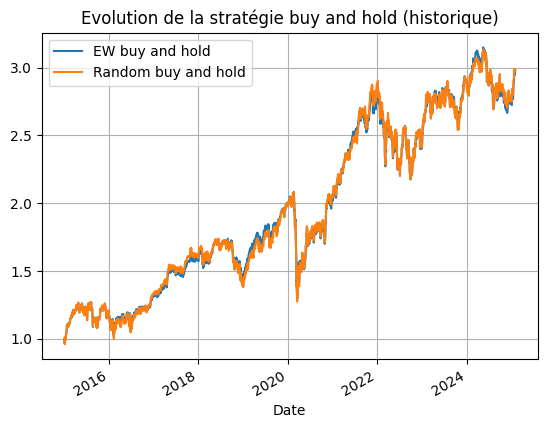

In [11]:
nb_stocks = log_return_jounalier_histo.shape[1]

allocations_EW = np.ones(nb_stocks) / nb_stocks
allocations_random = np.random.rand(nb_stocks)
allocations_random /= allocations_random.sum()

#evolution stratégie buy and hold
evolution_EW_buyandHold  = np.exp(np.cumsum(log_return_jounalier_histo)) * allocations_EW
evolution_random_buyandHold = np.exp(np.cumsum(log_return_jounalier_histo)) * allocations_random

evolution_EW_buyandHold.sum(axis=1).plot(label="EW buy and hold")
evolution_random_buyandHold.sum(axis=1).plot(label="Random buy and hold")
plt.legend()
plt.grid()
plt.title("Evolution de la stratégie buy and hold (historique)")

Text(0.5, 1.0, 'Evolution de la stratégie rebalancée tous les 5 jours (historique)')

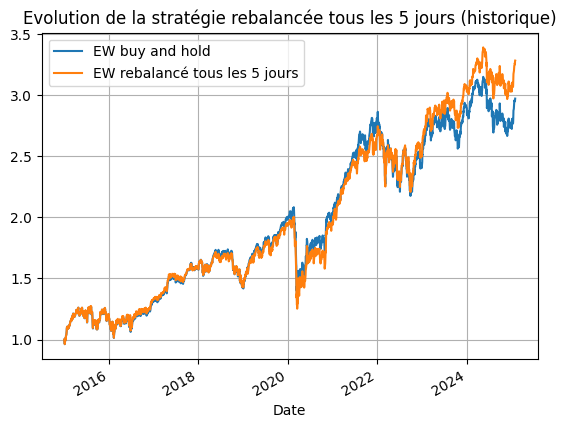

In [12]:
#strategie rebalancement tous les T jours
T = 5 # on rebalance tous les T jours 

evolution_EW_rebalancement = log_return_jounalier_histo * 0.0 # initialisation, même forme que log_return_jounalier_histo
#evolution_EW_rebalancement.iloc[0, :] = allocations_EW
evolution_EW_rebalancement.iloc[0:T, :] = np.exp(np.cumsum(log_return_jounalier_histo.iloc[0:T, :])) * allocations_EW
last_period = 0
for i in range(T, log_return_jounalier_histo.shape[0], T):
    evolution_EW_rebalancement.iloc[i:i+T, :] = np.exp(np.cumsum(log_return_jounalier_histo.iloc[i:i+T, :])) * evolution_EW_rebalancement.iloc[i-1, :].sum() * allocations_EW
    last_period = i
evolution_EW_rebalancement.iloc[last_period:, :] = np.exp(np.cumsum(log_return_jounalier_histo.iloc[last_period:, :])) * evolution_EW_rebalancement.iloc[last_period-1, :]


evolution_EW_buyandHold.sum(axis=1).plot(label="EW buy and hold")
evolution_EW_rebalancement.sum(axis=1).plot(label="EW rebalancé tous les " + str(T)+ " jours")
plt.legend()
plt.grid()
plt.title("Evolution de la stratégie rebalancée tous les " + str(T) + " jours (historique)")

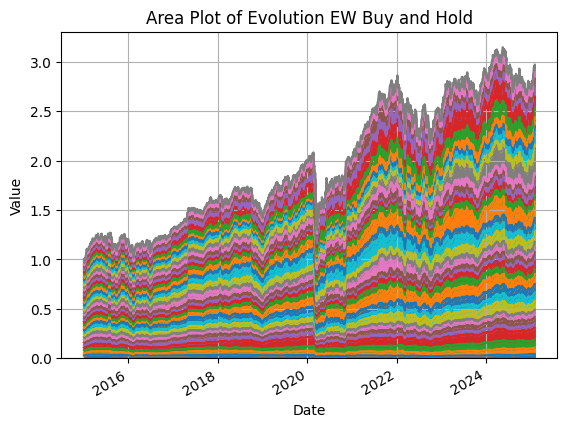

In [13]:
evolution_EW_buyandHold.plot.area()
plt.title("Area Plot of Evolution EW Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.legend().set_visible(False)
plt.show()

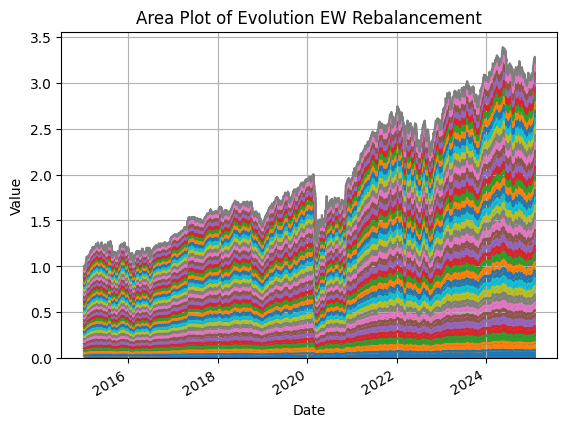

In [14]:
evolution_EW_rebalancement.plot.area()
plt.title("Area Plot of Evolution EW Rebalancement")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.legend().set_visible(False)
plt.show()

In [27]:
def generate_evolution(logReturn, allocation, T_rebalancement=-1):
    nb_periods = logReturn.shape[0]
    nb_stocks = logReturn.shape[1]
    
    evolution = logReturn * 0.0
    
    if T_rebalancement == -1:
        # Buy and hold strategy
        evolution = np.exp(np.cumsum(logReturn)) * allocation
    else:
        # Rebalancing strategy
        evolution.iloc[:T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[:T_rebalancement, :])) * allocation
        last_period = T_rebalancement
        for i in range(T_rebalancement, nb_periods, T_rebalancement):
            evolution.iloc[i:i+T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[i:i+T_rebalancement, :])) * evolution.iloc[i-1, :].sum() * allocation
            last_period = i
        evolution.iloc[last_period:, :] = np.exp(np.cumsum(logReturn.iloc[last_period:, :])) * evolution.iloc[last_period-1, :].sum() * allocation
    
    return evolution


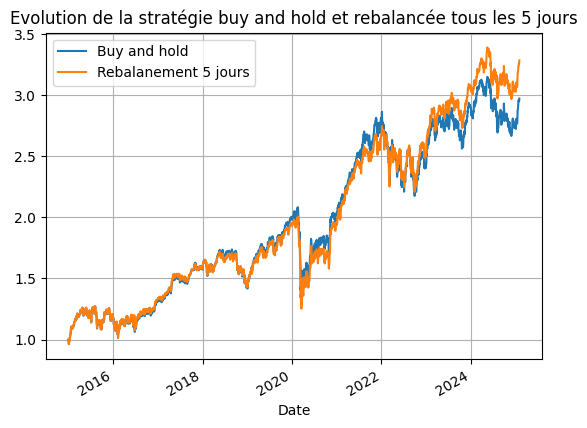

In [30]:
# Exemple d'utilisation
allocation = np.ones(nb_stocks) / nb_stocks
evolution_huyHold = generate_evolution(log_return_jounalier_histo, allocation)
evolution_Rebal = generate_evolution(log_return_jounalier_histo, allocation, T_rebalancement = 5)
evolution_huyHold.sum(axis=1).plot(label="Buy and hold")
evolution_Rebal.sum(axis=1).plot(label="Rebalanement 5 jours")
plt.title("Evolution de la stratégie buy and hold et rebalancée tous les 5 jours")
plt.legend()
plt.grid()
plt.show()

In [23]:
evolution_huyHold

Ticker,AC.PA,ACA.PA,AI.PA,AIR.PA,BN.PA,BNP.PA,BVI.PA,CA.PA,CAP.PA,CS.PA,...,RNO.PA,SAF.PA,SAN.PA,SGO.PA,STLAP.PA,STMPA.PA,SU.PA,TEP.PA,TTE.PA,VIE.PA
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316
2015-01-05,0.025977,0.025109,0.025501,0.026395,0.025642,0.025038,0.025137,0.025041,0.025966,0.025338,...,0.025398,0.026264,0.025559,0.025182,0.026316,0.025923,0.025170,0.026193,0.024741,0.025662
2015-01-06,0.025433,0.024626,0.025288,0.027007,0.025563,0.024383,0.024958,0.024841,0.024963,0.025062,...,0.025266,0.026445,0.025643,0.024782,0.026316,0.025644,0.025205,0.025768,0.024704,0.025303
2015-01-07,0.025560,0.024276,0.025402,0.027710,0.025861,0.023976,0.025008,0.024815,0.025068,0.025331,...,0.025209,0.026888,0.025915,0.024714,0.026316,0.026181,0.025363,0.025818,0.025264,0.025500
2015-01-08,0.026072,0.024867,0.026472,0.028654,0.026609,0.024753,0.025623,0.025943,0.025782,0.026378,...,0.026184,0.027692,0.027006,0.025713,0.026316,0.027056,0.026408,0.026325,0.026238,0.025975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-27,0.039689,0.063211,0.080245,0.119424,0.044052,0.062813,0.052660,0.019151,0.084442,0.085637,...,0.027545,0.135521,0.051969,0.085981,0.094143,0.124063,0.137199,0.048841,0.062160,0.074015
2025-01-28,0.040152,0.063720,0.080612,0.120116,0.044742,0.063156,0.053270,0.019371,0.087594,0.086391,...,0.027713,0.137250,0.052164,0.086815,0.093054,0.120044,0.126951,0.050667,0.062227,0.074970
2025-01-29,0.040079,0.064007,0.080941,0.119986,0.044410,0.063244,0.053843,0.019406,0.088337,0.085943,...,0.027876,0.137020,0.052236,0.086602,0.093345,0.120985,0.132971,0.049705,0.062283,0.074697


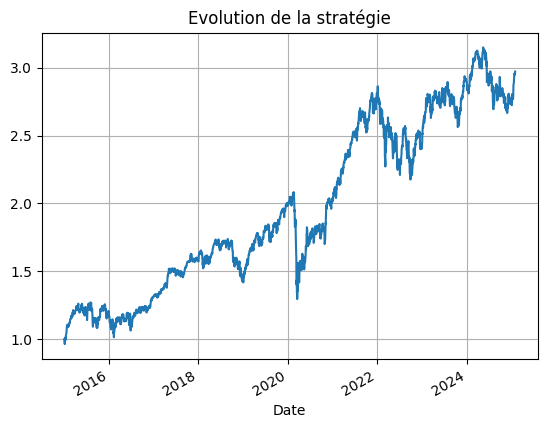

In [ ]:
def generate_evolution(logReturn, allocation, T_rebalancement=-1):
    nb_periods = logReturn.shape[0]
    nb_stocks = logReturn.shape[1]
    
    evolution = np.zeros_like(logReturn)
    
    if T_rebalancement == -1:
        # Buy and hold strategy
        evolution = np.exp(np.cumsum(logReturn)) * allocation
    else:
        # Rebalancing strategy
        evolution[:T_rebalancement, :] = np.exp(np.cumsum(logReturn[:T_rebalancement, :])) * allocation
        last_period = T_rebalancement
        for i in range(T_rebalancement, nb_periods, T_rebalancement):
            evolution[i:i+T_rebalancement, :] = np.exp(np.cumsum(logReturn[i:i+T_rebalancement, :])) * evolution[i-1, :].sum() * allocation
            last_period = i
        evolution[last_period:, :] = np.exp(np.cumsum(logReturn[last_period:, :])) * evolution[last_period-1, :].sum() * allocation
    
    return evolution

# Exemple d'utilisation
allocation = np.ones(nb_stocks) / nb_stocks
evolution_huyHold = generate_evolution(log_return_jounalier_histo, allocation)
evolution_Rebal = generate_evolution(log_return_jounalier_histo, allocation, 5)
evolution_huyHold_df = pd.DataFrame(evolution_huyHold, index=log_return_jounalier_histo.index, columns=log_return_jounalier_histo.columns)
evolution_Rebal_df = pd.DataFrame(evolution_Rebal, index=log_return_jounalier_histo.index, columns=log_return_jounalier_histo.columns)
evolution_huyHold_df.sum(axis=1).plot(label="Buy and hold")
evolution_Rebal_df.sum(axis=1).plot(label="Rebalanement 5jours")
plt.grid()
plt.show()